In [2]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pwd

/home/kaan/Desktop/Python/inzva/Palm-Fiction


In [4]:
curr_path = os.getcwd()
dataset = os.path.join(curr_path,"Processed_Imgs")
bounding_boxes = os.path.join(curr_path,"Processed_Bounds",)
joints_path = os.path.join(curr_path,"Processed_Joints")

dataset,bounding_boxes,joints_path

('/home/kaan/Desktop/Python/inzva/Palm-Fiction/Processed_Imgs',
 '/home/kaan/Desktop/Python/inzva/Palm-Fiction/Processed_Bounds',
 '/home/kaan/Desktop/Python/inzva/Palm-Fiction/Processed_Joints')

In [5]:
def get_bound_width_heght(bound):
  width = bound.loc['top_right']['x'] - bound.loc['top_left']['x']
  height =  bound.loc['bottom_left']['y'] - bound.loc['top_left']['y']
  return width,height

In [6]:
def get_bound(path):
    return pd.read_pickle(path)

In [7]:
def get_joints(path):
    return pd.read_pickle(path)

In [8]:
def get_img(path):
  img = plt.imread(path)
  return img

In [9]:
def get_item(index):
  if index == -1:
    index = random.randint(0,600)
  sample_img = os.path.join(dataset,str(index)+".jpg")
  sample_joints = os.path.join(joints_path,str(index)+".pkl")
  sample_bound = os.path.join(bounding_boxes,str(index)+".pkl")
  #print(index)
  #===============================================================#
  img = get_img(sample_img)
  #===============================================================#
  joints = get_joints(sample_joints)
  #===============================================================#
  bound_df = get_bound(sample_bound)
  #===============================================================#
  return img,joints,bound_df

In [10]:
img,joints,bound_df = get_item(-1)

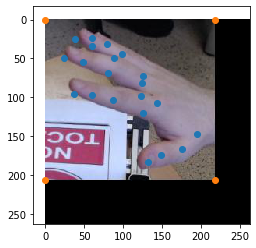

In [11]:
plt.imshow(img)
plt.scatter(joints['x'],joints['y'])
plt.scatter(bound_df['x'],bound_df['y'])

In [12]:
import torch
import torchvision
from torchvision import datasets, transforms

In [13]:
transformOps = transforms.Compose([
    transforms.ToTensor()
])

In [14]:
from PIL import Image

In [15]:
transformDefault = transforms.Compose([
    transforms.ToTensor()
])

In [16]:
def get_dataset_urls():
    return [url.split('.')[0] for url in os.listdir(dataset)]


In [17]:
def train_test_split(test_size=0.2):
    urls = get_dataset_urls()
    np.random.shuffle(urls)
    
    slc = int(len(urls)*test_size)
    train = urls[slc:]
    test = urls[:slc]
    return train,test

In [18]:
import cv2

def display_one(a, title1="Original"):
    plt.imshow(a, cmap="gray"), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()


In [31]:
class PalmFiction(torch.utils.data.Dataset):
    def __init__(self,urls,transform=transformDefault,target_transform=transformDefault,** kwargs):
        self.transform = transform
        self.target_transform = target_transform
        self.urls = urls

        #self.data contains all img urls
        self.data = []
        #self.targets contains all joints urls
        self.targets = []

        for url in self.urls:
            img_path = os.path.join(dataset,url + ".jpg")
            target_path = os.path.join(joints_path,url + ".pkl")
            self.data.append(img_path)
            self.targets.append(target_path)
        
        width_height = pd.read_csv("width_height.txt")
        self.width = width_height['width'][0]
        self.height = width_height['height'][0]
         
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path, target_path = self.data[index], self.targets[index]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(np.uint8(img / np.amax(img) * 255))
        target = pd.read_pickle(target_path)
        #print(type(target),target)
        #ntarget = np.empty(2,dtype=float)
        target= target[['x','y']].values.reshape(-1,2)
        #print(type(target),target)
        #target = np.array([ntarget])
        #target = target.astype('float').reshape(-1,2)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [32]:
train_url,test_url = train_test_split()
train = PalmFiction(train_url)
test = PalmFiction(test_url)

trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

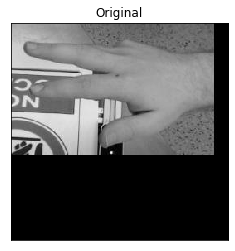

torch.Size([1, 263, 263])
torch.Size([1, 21, 2])


In [33]:
images, labels = next(iter(trainset))
display_one(torch.squeeze(images[10]))
print(images[0].shape)
print(labels[0].shape)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
import torch.nn as nn
import torch.nn.functional as functional
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=5, stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(270400,1000)
        self.fc2 = nn.Linear(1000,42)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        #print("X: ",x.shape)
        x = self.layer1(x)
        #print("X: ",x.shape)
        x = self.layer2(x)
        #print("X: ",x.shape)
        x = x.reshape(x.size(0),-1)
        #print("X: ",x.shape)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = Net()

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [38]:
# Train the model

def train_model(num_epochs):
    total_step = len(trainset)

    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(trainset):
            # Run the forward pass
            print(images.shape,labels.shape)
            outputs = net(images)
            #outputs = outputs.view(100,-1,2)
            labels = labels.view(100,-1)
            print(outputs.shape,labels.shape)
            print(outputs.dtype,labels.dtype)
            loss = criterion(outputs.type(torch.LongTensor), labels.type(torch.LongTensor))
            
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc = correct / total

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                            (correct / total) * 100))
        break
train_model(2)

torch.Size([100, 1, 263, 263]) torch.Size([100, 1, 21, 2])
torch.Size([100, 42]) torch.Size([100, 42])
torch.float32 torch.float64


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'